In [388]:
import numpy as np
import pickle
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
# import torch
from scipy.spatial.distance import cosine
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import csv
from tqdm import tqdm
import itertools

In [5]:
# x: [BATCH w, DIM VECS]: vectors to be projected
# m: [DIM VECS, DIM PROJECTION SUBSPACE]. m is a single projection. each column vector in m is a line onto which one projects
def get_projection(m):
  covariance_matrix = np.dot(np.transpose(m),m)
  inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
  #inverse_covariance_matrix = [DIM PROJECTION SUBSPACE, DIM PROJECTION SUBSPACE]
  
  def projection(x):
    #x: [DIM VECS, BATCH SIZE]
    #[DIM PROJECTION SUBSPACE, BATCH SIZE]
    uncorrected_projection_weights = np.dot(np.transpose(m),x.T)
    #[DIM PROJECTION SUBSPACE, BATCH SIZE]    
    projection_weights = np.dot(inverse_covariance_matrix,uncorrected_projection_weights)
    return np.dot(m,projection_weights).T
  
  return projection

In [6]:
# def get_literal_listener(prior_mean, sigma1, sigma2):
#   #prior_mean: [DIM VECS, 1]
#   prior_mean = np.expand_dims(prior_mean,axis=1)
#   def literal_listener(u):
#     #u: [DIM VECS, UTTERANCE BATCH SIZE]
#     posterior_mean = (sigma1*prior_mean + sigma2*u)*(sigma1^2*sigma2^2)/(sigma1^2+sigma2^2)
#     return posterior_mean
#   return literal_listener

In [7]:
# commenting scheme:
#   list(A) is a list of variables of type A
#   [x,y,z] is an array of shape (x,y,z)
  
#   DIM VECS = dimension of word embedding space
#   BATCH w = number of states w that are batched
#   NUM utts = number of utterances

In [618]:
# class contains several Bayesian pragmatic models:
# L0_Unbatched
# S1_Batched: fast S1, batched over w, and u (batch of u passed to L0): L0 is implicit in this S1
# S1_Unbatched: no batching: useful for understanding the code semantics clearly and for testing the batched version
# L1_Unbatched: no batched equivalent written
class Pragmatic_Model:
  # utterances : list(str). the utterance set U
  # projections : list(str). the projection set Q
  # vectors : dictionary: key:str,val:[dim vecs] of word embeddings
  # sigma1: hyperparameter for L0: variance of L0 prior. See paper
  # sigma2: hyperparameter for L0: variance of gaussian used in the semantics
  # mu1: hyperparameter for L0: the mean of the L0 prior: e.g. "man" in man is a shark. 
  def __init__(self,
              utterances,
              projections,
              vectors,
              sigma1,
              sigma2,
              mu1):
    
    self.utterances=utterances
    self.projections=projections
    # [NUM U, DIM VECS]
    self.utterance_vectors = np.asarray([vectors[u] for u in utterances]) 
    # [NUM Q, DIM VECS, DIM PROJECTION SUBSPACE]
    self.projection_vectors = (np.asarray([np.asarray([vectors[word]/np.linalg.norm(vectors[word]) for word in words]).T for words in self.projections]))
    self.vectors=vectors
    self.sigma1 = sigma1
    self.sigma2 = sigma2
    self.mu1 = mu1
    
    self.dimvecs = vectors["the"].shape[0]
    # how many dimensions does each projection have?
    self.dimsubspace = self.projection_vectors.shape[-1]
    
  # u : [DIM VECS]
  def L0_Unbatched(self,u):
    sigma1sq, sigma2sq = self.sigma1 ** 2, self.sigma2 ** 2
    mu = np.divide(np.add(self.mu1/sigma1sq, u/sigma2sq),  ((1/sigma1sq) + (1/sigma2sq)))
    sigma_base = ((1/sigma1sq) + (1/sigma2sq))**-1
    sigma = np.diag([sigma_base] * self.dimvecs)
    return mu,sigma
  
  # w : [1,DIM VECS]
  # q : [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Unbatched(self,w,q):
    
    projection = get_projection(q)
    # calculates a term that decreases with the euclidean distance of q(w) to q(u) where q(x) is x projected onto the subspace spanned by q
    def utility(w,projection,u):
      l0_posterior_mu, l0_posterior_sigma = self.L0_Unbatched(u=u)
      projected_w = projection(w)
      projected_l0_posterior_mu = projection(l0_posterior_mu)
      log_score = multivariate_normal(projected_l0_posterior_mu,l0_posterior_sigma).logpdf(projected_w)
      return log_score
    
    unnormed_log_probs = [utility(w=w,projection=projection,u=u) for u in self.utterance_vectors]
    norm = logsumexp(unnormed_log_probs)
    return unnormed_log_probs - norm
  
  # ws: [BATCH w, DIM VECS]
  # q: [DIM VECS, DIM PROJECTION SUBSPACE]
  def S1_Batched(self, ws,q):

    projection = get_projection(q)

    # obtain L0 posterior MU and SIGMA
    sigma1sq, sigma2sq = self.sigma1 ** 2, self.sigma2 ** 2
    inverse_sd = (1/sigma1sq) + (1/sigma2sq)
    sigma = np.diag([1/inverse_sd] * self.dimvecs)
    inverse_sigma = np.linalg.inv(sigma)
    l0_posterior_mu = np.divide(np.add(self.mu1/sigma1sq, self.utterance_vectors/sigma2sq),inverse_sd)

    # projections
    # [NUM UTTS, DIM VECS]
    projected_l0_posterior_mu = projection(l0_posterior_mu)
#     print("BATCHED",projected_l0_posterior_mu)
    # [BATCH w, DIM VECS]
    projected_ws = projection(ws)
    
    # compute logprob of gaussian
    # [BATCH w, NUM UTTS, DIM VECS]
    distances = np.expand_dims(projected_ws,1)-np.expand_dims(projected_l0_posterior_mu,0)
    # [BATCH w, NUM UTTS, DIM VECS]
    rescaled_distances = np.einsum('ij,abi->abj',np.sqrt(inverse_sigma),distances)
    # [BATCH w, NUM UTTS]
    unnormed_logprobs = -0.5*np.sum(np.square(rescaled_distances),axis=2)
    # [BATCH w,1]
    norm = np.expand_dims(logsumexp(unnormed_logprobs,axis=-1),-1)
    # [BATCH w, NUM UTTS]
    return unnormed_logprobs-norm
  
  def L1(self,u):
    #u: [DIM VECS, 1]
    #listener_mean: [DIM VECS, 1]
    start = -5
    stop = 5.01
    step = 0.01
    # intervals: [NUM INTERVALS]    
    intervals = np.arange(start=start,stop=stop,step=step)
    num_intervals = int((stop-start)/step)
    
    normal = multivariate_normal(mean=self.mu1, cov=[self.sigma1] * self.dimvecs)

    
    movement = {}
    marginal_projection_probs = np.zeros((len(self.projections)))
    for i in tqdm(range(len(self.projections))):
            
      q = self.projection_vectors[i]
      # assume q is a vector of unit length
      #q: [DIM VECS, 1]
      projection = get_projection(q)
      # [DIM VECS]
      projected_mu1 = projection(self.mu1)
      
      # [DIM VECS, NUM INTERVALS]
      projected_worlds = np.expand_dims(projected_mu1,0) + np.dot(q,np.expand_dims(intervals,0)).T

      # [NUM INTERVALS]
      speaker_log_likelihood = self.S1_Batched(projected_worlds,q)[:,u]
      
      # [NUM INTERVALS]
      world_log_priors = -1/(self.sigma1**2)*np.square(intervals)
      # TODO: draw from real gaussian and see if different
#       world_log_priors = np.asarray([normal.logpdf(i) for i in intervals])
      
      # [NUM INTERVALS]
      joint_probs = world_log_priors + speaker_log_likelihood
      left,right = np.exp(logsumexp(joint_probs[:num_intervals//2])), np.exp(logsumexp(joint_probs[1+num_intervals//2:]))
      movement[i]=right-left
      # SCALAR
      marginal_projection_prob = logsumexp(joint_probs)      
      marginal_projection_probs[i]=marginal_projection_prob
    
    norm = logsumexp(marginal_projection_probs)
    return marginal_projection_probs - norm, movement

  def L1_2D(self,u):
    #u: [DIM VECS, 1]
    #listener_mean: [DIM VECS, 1]
    start = -5
    stop = 5.1
    step = 0.01
    # intervals: [NUM INTERVALS]    
#     intervals = np.repeat(np.arange(start=start,stop=stop,step=step),self.dimsubspace)
#     intervals = intervals.reshape(2,intervals.shape[0]//2)
#     intervals = np.expand_dims(np.arange(start=start,stop=stop,step=step),0)
    intervals = np.stack([intervals]*self.dimsubspace)
    num_intervals = int((stop-start)/step)
    
    movement = {}
    marginal_projection_probs = np.zeros((len(self.projections)))
    for i in tqdm(range(len(self.projections))):
            
      q = self.projection_vectors[i]
      # assume q is a vector of unit length
      #q: [DIM VECS, 1]
      projection = get_projection(q)
      # [DIM VECS]
      projected_mu1 = projection(self.mu1)
      
      # [DIM VECS, NUM INTERVALS]
#       print(q[:,0,np.newaxis].shape)
      x = np.dot(q[:,0,np.newaxis],intervals)
      y = np.dot(q[:,1,np.newaxis],intervals)
      out = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
      print(x.shape,y.shape,out.shape,intervals.shape[1],intervals.shape[1]**2)
      print(out)
      raise Exception
    
      projected_worlds = np.expand_dims(projected_mu1,0) + np.dot(q,intervals).T

      # [NUM INTERVALS]
      speaker_log_likelihood = self.S1_Batched(projected_worlds,q)[:,u]
      
      # [NUM INTERVALS]
      world_log_priors = -1/(self.sigma1**2)*np.square(intervals)
      
      # [NUM INTERVALS]
      joint_probs = world_log_priors + speaker_log_likelihood
#       left,right = np.exp(logsumexp(joint_probs[:num_intervals//2])), np.exp(logsumexp(joint_probs[1+num_intervals//2:]))
#       movement[i]=right-left
      # SCALAR
      marginal_projection_prob = logsumexp(joint_probs)      
      marginal_projection_probs[i]=marginal_projection_prob
     
    norm = logsumexp(marginal_projection_probs)
    return marginal_projection_probs - norm, movement

In [619]:
simple_utterances = ["shark","swimmer","man"]
simple_projections = [["swims","vicious"],["vicious","swims"]]
# simple_projections = [["swims"],["vicious"]]

simple_vecs = {}
simple_vecs["swimmer"]=np.asarray([0.0,1.0])
simple_vecs["shark"]=np.asarray([1.0,1.0])
simple_vecs["man"]=np.asarray([0.0,0.0])
simple_vecs["vicious"]=np.asarray([1.0,0.0])
simple_vecs["swims"]=np.asarray([0.0,1.0])
simple_vecs["the"]=np.asarray([0.0,0.0])
simple_vecs["child"]=np.asarray([0.1,-1.0])
simple_vecs["nightmare"]=np.asarray([1.0,1.0])
simple_vecs["wonder"]=np.asarray([1.0,-1.0])

simple_mu1 = simple_vecs["man"]

In [620]:
simple_model = Pragmatic_Model(utterances=simple_utterances,
                                  projections=simple_projections,
                                  vectors=simple_vecs,
                                 sigma1=5.0,
                                 sigma2=0.5,
                                 mu1=simple_mu1)

In [621]:
# raw_output, movement = simple_model.L1(u=0)
raw_output, movement = simple_model.L1_2D(u=0)

UnboundLocalError: local variable 'intervals' referenced before assignment

In [564]:


results = sorted(list(zip(np.exp(raw_output),simple_projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q)
    if i > 20: break

0.6429603911301341 ['vicious']
0.35703960886986585 ['swims']


In [200]:
test_utterances = ["shark","swimmer","wonder","child"]
test_projections = [["swims"],["vicious"],["man"]]
test_mu1 = np.random.rand(5)
test_ws = np.random.rand(10,5)

test_vecs = {}
test_vecs["swimmer"]=np.random.rand(5)
test_vecs["shark"]=np.random.rand(5)
test_vecs["man"]=np.random.rand(5)
test_vecs["vicious"]=np.random.rand(5)
test_vecs["swims"]=np.random.rand(5)
test_vecs["child"]=np.random.rand(5)
test_vecs["nightmare"]=np.random.rand(5)
test_vecs["wonder"]=np.random.rand(5)
test_vecs["the"]=np.random.rand(5)

test_model = Pragmatic_Model(utterances=test_utterances,
                                  projections=test_projections,
                                  vectors=test_vecs,
                                 sigma1=1.0,
                                 sigma2=2.0,
                                 mu1=test_mu1)

0.33373021266959213 ['swims'] -23.495606630748796
0.3336409106174595 ['vicious'] -19.856699436855706
0.33262887671294833 ['man'] -11.031278492257343


In [96]:
#test that S1_Batched and S1_Unbatched are equivalent, up to numerical precision
q = test_model.projection_vectors[0]
batched = test_model.S1_Batched(ws=test_ws,q=q)

for i,w in enumerate(test_ws):
  unbatched = test_model.S1_Unbatched(w=test_ws[i],q=q)
  b = batched[i]
  ub = unbatched
  print(b,ub)
  assert(np.allclose(b,ub))


[-1.393 -1.379 -1.384 -1.389] [-1.393 -1.379 -1.384 -1.389]
[-1.387 -1.385 -1.386 -1.387] [-1.387 -1.385 -1.386 -1.387]
[-1.391 -1.381 -1.385 -1.388] [-1.391 -1.381 -1.385 -1.388]
[-1.379 -1.394 -1.389 -1.383] [-1.379 -1.394 -1.389 -1.383]
[-1.383 -1.391 -1.388 -1.384] [-1.383 -1.391 -1.388 -1.384]
[-1.398 -1.373 -1.382 -1.392] [-1.398 -1.373 -1.382 -1.392]
[-1.395 -1.376 -1.383 -1.39 ] [-1.395 -1.376 -1.383 -1.39 ]
[-1.379 -1.395 -1.389 -1.383] [-1.379 -1.395 -1.389 -1.383]
[-1.392 -1.381 -1.384 -1.389] [-1.392 -1.381 -1.384 -1.389]
[-1.393 -1.379 -1.384 -1.389] [-1.393 -1.379 -1.384 -1.389]


In [47]:
# test that batched projection is equivalent to unbatched projection
m = np.random.rand(10,3)
x = np.random.rand(2,10)

projection = get_projection(m)
projected_x = projection(x)
assert(np.allclose(projection(x)[0],projection(x[0])))
assert(np.allclose(projection(x)[1],projection(x[1])))

In [617]:
# pickled version of GLoVE
vecs = pickle.load(open("/Users/reuben/Downloads/glove.840B.plain300",'rb'))

def get_words(with_freqs=False):
	nouns, adjs, words = {},{},set()
	with open('../dist_rsa/data/concreteness.csv', newline='') as csvfile:
		r = csv.reader(csvfile, delimiter=',', quotechar='|')
		for i,row in enumerate(r):
			if i>0:
				is_bigram = float(row[1])!=0
				is_noun = (row[8])=='Noun'		
				is_adj = (row[8])=='Adjective'
				is_adv = (row[8])=='Adverb'
				freq = row[7]
				if not is_bigram:
					if is_noun:
						if with_freqs:nouns[row[0]]=float(row[2]),freq
						else: nouns[row[0]]=float(row[2])
					if is_adj:
						if with_freqs: adjs[row[0]]=float(row[2]),freq
						else: adjs[row[0]]=float(row[2])
		return nouns,adjs

In [522]:
abstract_threshold = 2.5
concrete_threshold = 3.0

target = "time"
source = "river"

nouns,adjs = get_words(with_freqs=False)
nouns = [noun for noun in nouns if noun in vecs]
adjectives = [adjective for adjective in adjectives if adjective in vecs]
adjectives = [a for a in adjs if adjs[a] > concrete_threshold and a in vecs]
utterances = sorted(nouns,key=lambda x: cosine(vecs[x],vecs[target]))
projections = [a for a in adjs if adjs[a] < abstract_threshold and a in vecs]
projections = sorted(projections,key=lambda x:cosine(vecs[x],vecs[target]))
projections = [[x] for x in projections]

if source in utterances: utterances.remove(source)
if target in utterances: utterances.remove(target)

utterances = [source]+utterances[:100]
projections = projections[:100]

# projections = [["unstable"],["vicious"]]

pragmatic_model = Pragmatic_Model(utterances=utterances,
                                  projections=projections,
                                  vectors=vecs,
                                 sigma1=0.1,
                                 sigma2=0.1,
                                 mu1=vecs[target])


In [520]:
raw_output, movement = pragmatic_model.L1(u=0)


 33%|███▎      | 30/90 [00:00<00:00, 123.87it/s]

(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)



 77%|███████▋  | 69/90 [00:00<00:00, 151.92it/s]

(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)



100%|██████████| 90/90 [00:00<00:00, 175.10it/s]

(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)
(101, 50) (50, 2)


In [521]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q,movement[pragmatic_model.projections.index(q)])
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['good', 'supposed'], ['good', 'best'], ['good', 'likely'], ['good', 'difficult'], ['good', 'sure'], ['good', 'able'], ['good', 'prior'], ['good', 'entire'], ['good', 'regular'], ['supposed', 'good']]
utterance river


KeyError: 60

In [536]:
# 2D CASE

abstract_threshold = 2.5
concrete_threshold = 3.0

target = "time"
source = "river"

nouns,adjs = get_words(with_freqs=False)
nouns = [noun for noun in nouns if noun in vecs]
adjectives = [adjective for adjective in adjectives if adjective in vecs]
adjectives = [a for a in adjs if adjs[a] > concrete_threshold and a in vecs]
utterances = sorted(nouns,key=lambda x: cosine(vecs[x],vecs[target]))
projections = [a for a in adjs if adjs[a] < abstract_threshold and a in vecs]
projections = sorted(projections,key=lambda x:cosine(vecs[x],vecs[target]))
# projections = [[x] for x in projections]

if source in utterances: utterances.remove(source)
if target in utterances: utterances.remove(target)

utterances = [source]+utterances[:50]
projections = projections[:50]
projections = [[x,y] for (x,y) in itertools.product(projections,projections) if x!=y and x>y]

pragmatic_model = Pragmatic_Model(utterances=utterances,
                                  projections=projections,
                                  vectors=vecs,
                                 sigma1=0.1,
                                 sigma2=0.1,
                                 mu1=vecs[target])


In [537]:
raw_output, movement = pragmatic_model.L1_2D(u=0)


100%|██████████| 1225/1225 [00:24<00:00, 49.73it/s]

In [538]:
print("baseline",projections[:10])
print("utterance",pragmatic_model.utterances[0])
results = sorted(list(zip(np.exp(raw_output),projections)),key=lambda x: x[0],reverse=True)

for i,(prob,q) in enumerate(results):
    print(prob,q)
    if i > 20: break
# print(movement[pragmatic_model.projections.index(["pure"])])


baseline [['good', 'best'], ['good', 'difficult'], ['good', 'able'], ['good', 'entire'], ['good', 'free'], ['good', 'extended'], ['good', 'easy'], ['good', 'different'], ['good', 'bad'], ['good', 'certain']]
utterance river
0.4382462692175309 ['great', 'entire']
0.2641609453667568 ['extended', 'entire']
0.18821986855659384 ['great', 'extended']
0.031015653111848996 ['major', 'extended']
0.029507998835353016 ['major', 'important']
0.014861581205509383 ['major', 'great']
0.007481177889361597 ['important', 'direct']
0.00635096459370982 ['important', 'extended']
0.005704300187020967 ['major', 'direct']
0.003870983013933641 ['major', 'entire']
0.0035785604566456256 ['other', 'important']
0.0024493125224575264 ['other', 'direct']
0.0008024165114743339 ['other', 'limited']
0.0006384590167601447 ['similar', 'particular']
0.0005668991933636875 ['similar', 'limited']
0.0004235051287421882 ['extended', 'direct']
0.00037532891626736474 ['similar', 'other']
0.00025388022062583065 ['particular', 'li

AttributeError: 'BarContainer' object has no attribute 'figure'

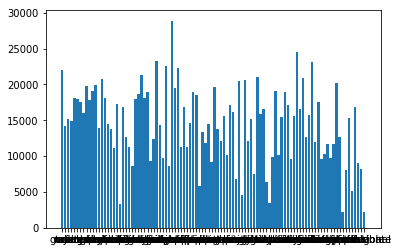

In [97]:
import matplotlib
from matplotlib import pyplot

_, projs = list(zip(*results))
projs = list(projections)
movements = [movement[pragmatic_model.projections.index(i)] for i in projs]
projs = [i[0] for i in projs]
plt = matplotlib.pyplot.bar(projs, movements)
plt.figure(figsize=(20,10))

In [69]:
movements

[2147.017405218223,
 3495.7439158397683,
 2268.1680566728537,
 8258.524686373079,
 5178.132070887048,
 6763.518376771273,
 5791.617031160124,
 9027.01478738262,
 12151.25643154484,
 9912.127670659851,
 11726.788826559703,
 4538.9903182641865,
 8067.115409356433,
 9179.319019594546,
 6451.510168153902,
 10114.627502418898,
 15395.901346026883,
 9621.38724521442,
 10346.083914868519,
 12335.257010737303,
 11974.892323755917,
 12685.165559674242,
 3253.6420529614697,
 12621.295173053542,
 15231.509071929235,
 11290.065479289016,
 14291.341563600363,
 11244.201016445408,
 9697.508023469793,
 15584.965445873942,
 14586.96337627311,
 13728.945051719846,
 12037.96130952477,
 7444.991499410389,
 9363.678399955104,
 8614.058764070462,
 16630.712019882463,
 17111.21668488429,
 16107.75755675892,
 17089.843001482965,
 10096.354778902496,
 8644.217257180455,
 11781.347559607635,
 9549.090772432115,
 15737.385576793095,
 17558.445136261875,
 14516.548966205006,
 16796.344134596304,
 13355.526790185

projections

5.160355464594687